# Centroid mapping for cell type identification

Updated version of `##_centroid_mapping.ipynb`

First two cells: dependencies and helper functions

In [10]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from rich.table import Table
from rich.console import Console
from tqdm.notebook import tqdm

In [11]:
def corr2(
        a: np.ndarray,
        b: np.ndarray
):
    """Build corr2 (Pearson correlation coefficient) matlab function"""
    a = np.ravel(a).astype(float) - np.mean(a)
    b = np.ravel(b).astype(float) - np.mean(b)
    r = np.dot(a, b) / np.sqrt(np.dot(a, a) * np.dot(b, b))
    return r


def corr_2_matrix(
        a: np.ndarray,
        b: np.ndarray
):
    """corr2 func extended to 2d input matrices.

    Parameters
    ----------
    a : np.ndarray
        2d array to correlate. Has shape (samples_a, observations).
    b : np.ndarray
        Another 2d array to correlate. Has shape (samples_b, observations).

    Returns
    -------
    corr_matrix
        2d array with shape (samples_a, samples_b). The value at [i, j] is the Pearson correlation between the i_th sample in array `a` and j_th sample in array `b`.

    """
    # Center columns (genes)
    mat_a = a - a.mean(axis=1, keepdims=True)  # cell x gene matrix
    mat_b = b - b.mean(axis=1, keepdims=True)  # cell x gene matrix

    # Compute numerator: X^T @ Y (dot product of centered columns)
    numerator = mat_a @ mat_b.T  # shape: (n_cells_a, n_cells_b)

    # Compute denominator: column-wise norms, shape = (n_cells1, n_cells2)
    denominator = np.outer(np.linalg.norm(mat_a, axis=1), np.linalg.norm(mat_b, axis=1))

    # Pearson correlation matrix
    corr_matrix = numerator / denominator
    return corr_matrix


def format_str_index(
        index,
        replace: str = '_'
):
    """Format string index values to uppercase alphanumeric characters.

    Parameters
    ----------
    index : pd.Index | pd.Series
        Index of labels to format as strings.
    replace : str, optional
        Character used to replace non-alphanumeric characters in `index`.
        Defaults to '_'.

    Returns
    -------
    formatted_index : pd.Series
        `index` with non-alphanumeric characters replaced with `replace` and other characters converted to uppercase.
    """
    formatted_index = index.to_series().str.replace(r'[^0-9A-Za-z]', replace, regex=True).str.upper()
    return formatted_index


def normalize_counts(
        count_matrix: pd.DataFrame,
        counts: pd.Series = None,
        scalar: float = None,
        norm_seq_depth: bool = True,
        gene_x_cell: bool = True,
        log: bool = True
):
    """Normalize a count matrix to total UMI counts per cell.

    Parameters
    ----------
    count_matrix : pd.DataFrame
        One axis corresponds to identified genes. Other axis corresponds to sequenced cells.
    counts : pd.Series, optional
        Total UMI counts per cell_id (index). Useful if `count_matrix` is a filtered version of a larger DataFrame.
        Defaults to None, in which case counts are summed from `count_matrix`.
    scalar : float, optional
        Scale factor with which to adjust normalized counts.
        Defaults to None, in which case counts are not scaled.
    norm_seq_depth : bool, optional
        If True, normalize counts to total UMIs per cell and scale output values by `scalar`.
        Defaults to False.
    gene_x_cell : bool, optional
        If True, `count_matrix` is a [gene, cell] matrix. If False, `count_matrix` is a [cell, gene] matrix.
    log : bool, optional
        If True, take logarithm of counts + 1

    Returns
    -------
    new_counts : pd.DataFrame
        `count_matrix` normalized to total UMI counts per cell and scaled.
    """
    new_counts = counts
    if norm_seq_depth:
        counts = counts if counts is not None else count_matrix.sum(numeric_only=True, axis=int(not gene_x_cell))
        new_counts = count_matrix.divide(counts, axis=int(gene_x_cell))
        new_counts = new_counts if scalar is None else new_counts * scalar

    new_counts = np.log1p(new_counts) if log else new_counts
    return new_counts


def centroid_mapping(
        ref_counts,
        new_counts,
        ref_metadata,
        write_corr_scores_df: Path,
        type_col: str,
        step: int
):
    """
    Parameters
    ----------
    ref_counts : pd.DataFrame
        Sparse reference matrix. Normalized and filtered to relevant genes. Cell x gene matrix.
    new_counts : pd.DataFrame
        Sparse sample matrix. Normalized and filtered to relevant genes. Cell x gene matrix.
    ref_metadata : pd.DataFrame
        Metadata associated with cells in `ref_counts`.
    write_corr_scores_df : Path
        where to save correlation coefficient matrix on local machine
    type_col : str
        name of column in `ref_metadata` that contains cell type labels.
    step : int, optional

    Returns
    -------
    corr_Scores : pd.DataFrame
    type_assignment : pd.DataFrame
    """
    # add cell type column
    ref_counts[type_col] = ref_metadata.loc[ref_counts.index, type_col]

    # build centroids table of mean for each variable gene within a cluster
    ref_counts = ref_counts.groupby(type_col).mean()  # cluster x gene

    # For each cell, calculate correlations across all genes for each centroid
    corr_scores = []
    for i in range(0, new_counts.shape[0], step):
        subset = new_counts.iloc[i:i+step]
        corr_scores += [
            pd.DataFrame(corr_2_matrix(subset.to_numpy(), ref_counts.to_numpy()), index=subset.index, columns=ref_counts.index)]

    corr_scores = pd.concat(corr_scores)
    corr_scores.to_csv(write_corr_scores_df)

    # Assign clusters based on highest value concordance (excluding any NaNs)
    type_assignment = corr_scores.idxmax(axis='columns').to_frame(name=type_col)
    return corr_scores, type_assignment


def calculate_embeddings(
        ref_counts: pd.DataFrame,
        new_counts: pd.DataFrame,
        ref_umap: pd.DataFrame,
        umap_cols: list,
        type_col: str,
        use_median: bool,
        knn: int,
        step: int
):
    """
    Parameters
    ----------
    ref_counts :
        sparse reference matrix
    new_counts :
        sparse sample matrix
    ref_umap :
        coordinates representing the embeddings for each cell from the reference atlas
    umap_cols :
        umap coord column names in `ref_umap`
    type_col : str
        name of column in `ref_metadata` that contains cell type labels.
    use_median : bool
        whether to calculate the median or a weighted average for the query embeddings
    knn : int
        number of neighbors to consider when selecting median/weighted mean
    step : int
        Number of cells to map per iteration

    Returns
    -------
    assignment_positions : pd.DataFrame
    """
    # chunk over cells in new dataset
    assignment_positions = {}
    for i in range(0, new_counts.shape[0], step):
        sub_new = new_counts.iloc[i:i+step]
        corr_scores = []

        # chunk over cells in reference dataset
        for j in range(0, ref_counts.shape[0], step):
            sub_ref = ref_counts.iloc[j:j+step]

            # compute new_cells x ref_cells expression correlation matrix
            corr_scores += [
                pd.DataFrame( corr_2_matrix(sub_new.to_numpy(), sub_ref.to_numpy()), index=sub_new.index, columns=sub_ref.index)]

        # join batches by new cell id and iterate over new_cells
        for new_cell_id, row in pd.concat(corr_scores, axis=1).iterrows():
            # select knn reference cells based on largest correlations
            row = row.nlargest(knn)

            # extract umap coordinates for selected reference cells
            coords = ref_umap.loc[row.index, umap_cols].to_numpy()

            # count number of mapped types for reference cells
            n_types = len(ref_umap.loc[row.index, type_col].unique())

            # take median/corr weighted average of reference UMAP coordinates
            coords = np.median(coords, axis=0) if use_median else np.average(coords, axis=0, weights=row.to_numpy())
            assignment_positions[new_cell_id] = [n_types] + coords.tolist()

    assignment_positions = pd.DataFrame.from_dict(
        assignment_positions, orient="index", columns=["n_types"] + list(umap_cols))
    return assignment_positions

Third cell: pipeline
  - load reference list of variable genes
  - chunk load, normalize, and filter reference dataset
  - chunk load, normalize, and filter query dataset
  - map query cells to centroids of cell types in reference dataset
  - calculate embeddings of query cells based on reference umap coordinates

In [14]:
def pipeline(
        ref_counts_path: Path,
        ref_genes_path: Path,
        ref_metadata_path: Path,
        query_dir: Path,
        out_dir: Path,
        umap_cols: list,
        scale_factor: float = 10_000,
        norm_seq_depth: bool = True,
        use_median: bool = True,
        knn: int = 10,
        type_col: str = 'type_updated',
        step: int = 1_000
):
    """Centroid mapping pipeline

    Parameters
    ----------
    ref_counts_path : Path
        Path to reference count matrix.csv
    ref_genes_path : Path
        Path to reference list of variable genes.csv
    ref_metadata_path : Path
        Path to reference metadata.csv
    query_dir : Path
        Path to directory of query datasets.csv.
    out_dir : Path
        Path to save output files and plots.
    umap_cols : list[str]
        Names of columns in `ref_metadata_path` that contain umap coordinates.
    scale_factor : float
        Scale factor with which to adjust normalized counts.
    norm_seq_depth : bool
        Whether to normalize counts by depth and `scale_factor`.
    use_median : bool
        If True, compute query cell embeddings with median value. If False, use weighted average.
    knn : int
        Number of nearest neighbors to consider when calculating query umap embeddings.
    type_col : str
        Column name in `ref_metadata_path` that contains cell type labels.
    step : int
        Number of cells to load or map per iteration.
    """
    corr_dir = out_dir.joinpath("corr_scores")
    plot_dir = out_dir.joinpath("umap_plots")
    for subdir in (corr_dir, plot_dir):
        subdir.mkdir(exist_ok=True, parents=True)

    filtered_path = out_dir.joinpath("filtered_normed_wang_ref.csv")
    total_gene_path = out_dir.joinpath("filtered_common_genes.csv")
    assignment_path = out_dir.joinpath("mapped_centroids.csv")

    # extract relevant genes and metadata from reference files
    ref_variable_genes = pd.read_csv(ref_genes_path, usecols=['x'])['x']
    ref_metadata = pd.read_csv(ref_metadata_path, index_col=0)

    # clean up cell ids to match those in raw data file
    ref_metadata.index = format_str_index(ref_metadata.index)

    # only load relevant genes from reference dataset
    print(f'\nReference dataset file available? {filtered_path.is_file()}')
    if not filtered_path.is_file():
        ref_data = []
        counts = None
        start_time = time.time()
        for chunk in tqdm(  # gene x cell matrix
                pd.read_csv(ref_counts_path, index_col=0, chunksize=step), desc='loading...'):
            # clean cell ids, revert ref_data transformed with log1p
            chunk = np.expm1(chunk)
            chunk.columns = format_str_index(chunk.columns)

            # keep running total of UMI counts per cell, for all genes
            chunk_sum = chunk.sum(axis=0, numeric_only=True)
            counts = chunk_sum if counts is None else counts + chunk_sum

            # filter to only variable genes, cells with metadata
            chunk = chunk.loc[
                chunk.index.isin(ref_variable_genes), chunk.columns.intersection(ref_metadata.index)]
            ref_data += [chunk]

        # concat chunked raw data, normalize, save
        print(f'load time: {time.time() - start_time:.2f}s')
        start_time = time.time()
        normalize_counts(
            pd.concat(ref_data), counts=counts, scalar=scale_factor, norm_seq_depth=norm_seq_depth, gene_x_cell=True, log=True).to_csv(filtered_path)
        print(f'norm time: {time.time() - start_time:.2f}s')

    # load and convert to cell x gene matrix
    ref_data = pd.read_csv(filtered_path, index_col=0).T
    common_genes = ref_data.columns
    print(f'\nreference cell count: {ref_data.shape[0]}')
    print(f'variable genes count: {ref_data.shape[1]}')

    '''------ iterate over query datasets ------'''
    assignments = []
    logging = {}
    for query_path in tqdm(list(query_dir.glob('[!.]*.csv')), desc="mapping..."):
        '''------ normalize and filter query dataset ------'''
        query_data = normalize_counts(
            pd.read_csv(query_path, index_col=0), scalar=scale_factor, norm_seq_depth=norm_seq_depth, gene_x_cell=True, log=True).T  # index is cell

        # Identify overlapping genes between reference and query datasets
        gg = ref_data.columns.intersection(query_data.columns)
        query_data = query_data.loc[:, gg]
        common_genes = common_genes.intersection(gg)

        '''------ centroid mapping ------'''
        centroid_time = time.time()
        corr, cell_type = centroid_mapping(
            ref_counts=ref_data.loc[:, gg], new_counts=query_data, ref_metadata=ref_metadata, type_col=type_col, step=step, write_corr_scores_df=corr_dir.joinpath(query_path.name))
        centroid_time = time.time() - centroid_time

        # get peak correlation for each cell
        corr = corr.max(axis=1).to_frame(name='high_score')
        corr[['dataset_id', 'cbc']] = corr.index.to_series().str.split(
            '_', n=1, expand=True)

        '''------ embed in reference umap ------'''
        embedding_time = time.time()
        coords = calculate_embeddings(
            ref_counts=ref_data.loc[:, gg], new_counts=query_data, ref_umap=ref_metadata, umap_cols=umap_cols, type_col=type_col, use_median=use_median, knn=knn, step=step)
        embedding_time = time.time() - embedding_time
        assignments += [pd.concat([corr, cell_type, coords], axis=1)]

        # log data from current loop
        logging[query_path.name] = (len(gg), centroid_time, embedding_time)

    # save list of common genes as csv
    print(f'common genes across all datasets: {len(common_genes)}')
    common_genes.to_series().to_csv(total_gene_path, index=False, header=False)

    # print logged metadata
    table = Table(title='Mapping Summary')
    table.add_column('dataset', style='bold cyan')
    table.add_column('n genes', style='magenta')
    table.add_column('t map (sec)', style='green')
    table.add_column('t embed (sec)', style='green')
    for d, (g, t_c, t_e) in logging.items():
        table.add_row(d, str(g), f'{t_c:.2f}', f'{t_e:.2f}')

    Console().print(table)

    assignments = pd.concat(assignments)
    mapping = {  # desired label: [dataset_ids]
        'SADB-19 cell': ['s1', 's2', 's3', 's4', 's5'],
        'CVS-N2c cell': ['c1', 'c2', 'c3', 'c4'],
        'CVS-N2c nuc': ['n1', 'n2', 'n3', 'n4'],
        'Uninfected cell': ['u1'], 'Uninfected nuc': ['u2']}
    for k, v in mapping.items():
        assignments.loc[assignments['dataset_id'].isin(v), 'cbc'] = k

    assignments.to_csv(assignment_path)

    '''------ plot high score distribution ------'''
    sns.set_theme(style="ticks", rc={
        "axes.spines.right": False, "axes.spines.top": False})
    plt.figure(figsize=(6, 3))
    plt.xticks(rotation=45)
    sns.violinplot(
        data=assignments, x='dataset_id', y='high_score', hue='dataset_id', legend=False, alpha=0.5)
    plt.show()
    plt.savefig(
        plot_dir.joinpath('peak correlations.png'), dpi=300,
        bbox_inches='tight')
    plt.close()

    '''------ plot mapped type distribution ------'''
    print(f'average number of mapped types/dataset at knn {knn}')
    print(assignments[['dataset_id', 'n_types']].groupby('dataset_id').mean())
    plt.figure(figsize=(6, 3))
    plt.xticks(rotation=45)
    sns.violinplot(
        data=assignments, x='dataset_id', y='n_types', hue='dataset_id', legend=False, alpha=0.5)
    plt.show()
    plt.savefig(plot_dir.joinpath('mapped types.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # Drop all rows where high_score is <0.2
    total_cells = assignments.shape[0]
    assignments = assignments.query('high_score >= 0.2')
    print(f'\nNumber of cells pre-thresholding: {total_cells}')
    print(f'Number of cells post-thresholding: {assignments.shape[0]}')
    print(f'Percentage: {100 * assignments.shape[0] / total_cells:.2f}%')

    '''------ plot cell types on umap ------'''
    unique = ref_metadata[type_col].unique()
    hue_map = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    kwargs = { 'legend': False, 'palette': hue_map, 'hue_order': unique, 's': 5, 'marker': '.'}
    for dset in tqdm(assignments['dataset_id'].unique(), desc='plot...'):
        subdata = assignments[assignments['dataset_id'] == dset]
        n_cols = 2
        fig, axes = plt.subplots(
            ncols=n_cols, sharex=True, sharey=True, figsize=(3 * n_cols, 3), constrained_layout=True)
        sns.scatterplot(
            data=ref_metadata, x=umap_cols[0], y=umap_cols[1], hue=type_col, ax=axes[0], **kwargs)
        sns.scatterplot(
            data=subdata, x=umap_cols[0], y=umap_cols[1], hue=type_col, ax=axes[1], **kwargs)
        titles = ["reference", dset]
        for ax, t in zip(axes, titles):
            ax.set_title(t)

        plt.show()
        plt.savefig(plot_dir.joinpath(f'{dset} dataset.png'), dpi=300, bbox_inches='tight')
        plt.close()

Final cell: entry point
NOTE: code expects that count matrices are gene x cell, where each row corresponds to a gene and each column to a cell.


Reference dataset file available? True

reference cell count: 69539
variable genes count: 3000


mapping...:   0%|          | 0/15 [00:00<?, ?it/s]

common genes across all datasets: 2412


                     Mapping Summary                     
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ dataset       ┃ n genes ┃ t map (sec) ┃ t embed (sec) ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ u2_sparse.csv │ 2412    │ 1.12        │ 106.37        │
│ c2_sparse.csv │ 2412    │ 0.84        │ 72.98         │
│ n3_sparse.csv │ 2412    │ 0.67        │ 44.92         │
│ s5_sparse.csv │ 2412    │ 0.67        │ 8.61          │
│ s2_sparse.csv │ 2412    │ 0.59        │ 34.93         │
│ n4_sparse.csv │ 2412    │ 0.54        │ 16.49         │
│ n1_sparse.csv │ 2412    │ 0.57        │ 21.87         │
│ n2_sparse.csv │ 2412    │ 0.51        │ 13.52         │
│ s4_sparse.csv │ 2412    │ 0.55        │ 13.56         │
│ s1_sparse.csv │ 2412    │ 0.52        │ 4.77          │
│ c3_sparse.csv │ 2412    │ 0.52        │ 11.49         │
│ c4_sparse.csv │ 2412    │ 0.51        │ 11.95         │
│ s3_sparse.csv │ 2412    │ 0.52        │ 12.91         │
│ u1_sparse.csv │ 2412    │ 1.18        │ 59.69         │
│ c1_sparse.csv │ 2412    │ 0.57        │ 19.32         │
└───────────────┴─────────┴─────────────┴───────────────┘

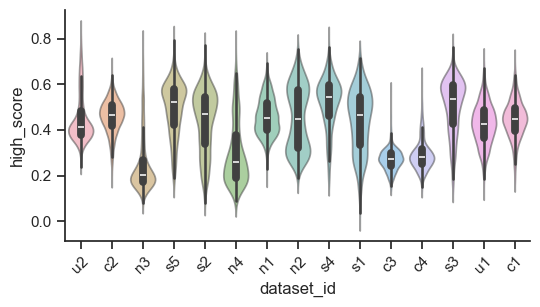

average number of mapped types/dataset at knn 10
             n_types
dataset_id          
c1          2.269828
c2          1.775419
c3          5.836814
c4          5.249137
n1          2.492619
n2          4.108075
n3          4.921449
n4          4.872781
s1          1.759615
s2          2.076975
s3          1.950886
s4          1.897436
s5          1.872162
u1          2.376133
u2          3.990665


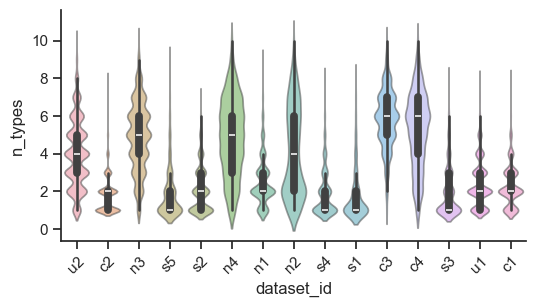


Number of cells pre-thresholding: 49554
Number of cells post-thresholding: 46688
Percentage: 94.22%


plot...:   0%|          | 0/15 [00:00<?, ?it/s]

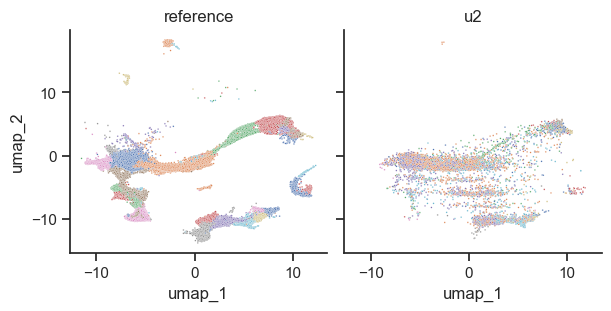

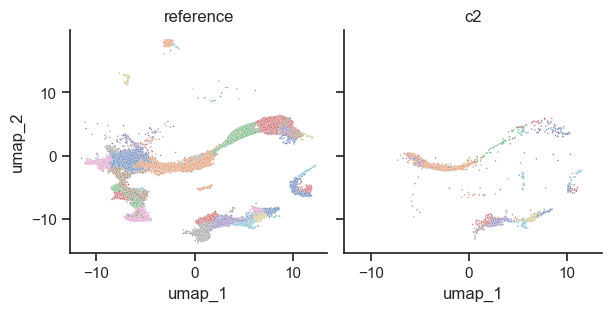

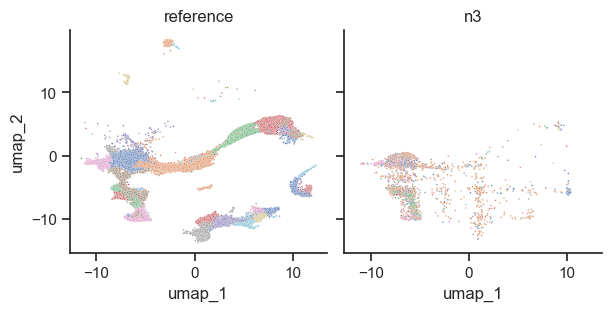

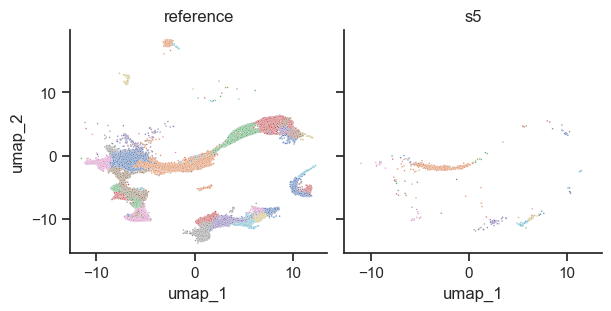

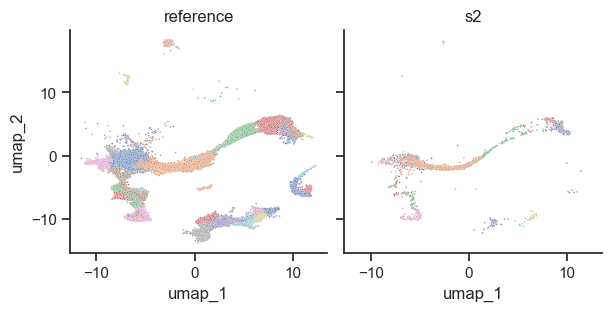

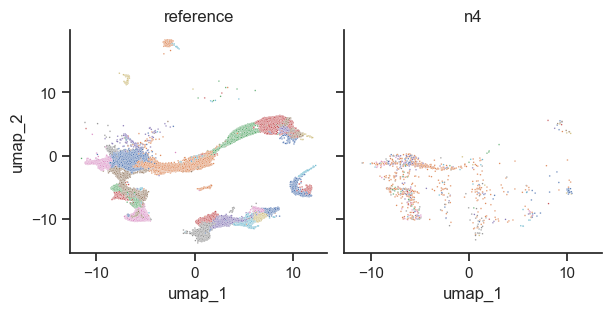

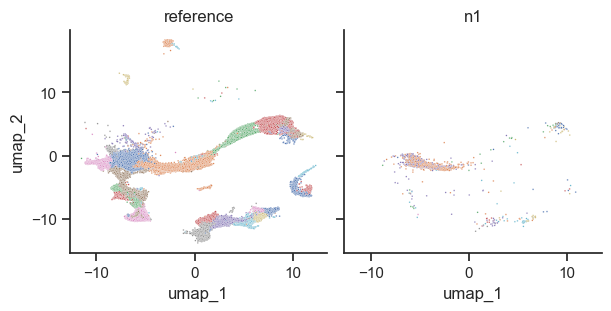

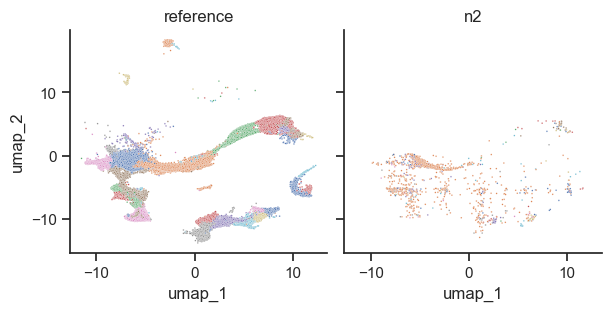

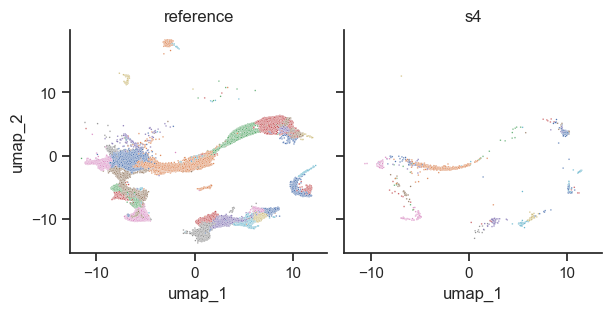

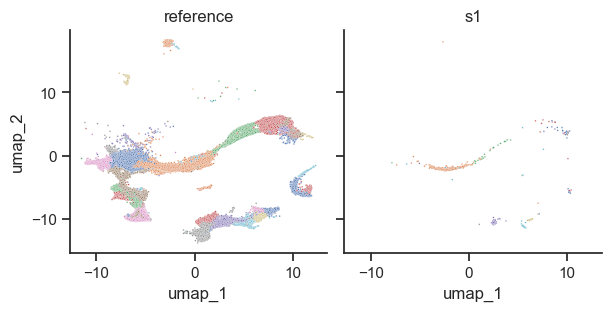

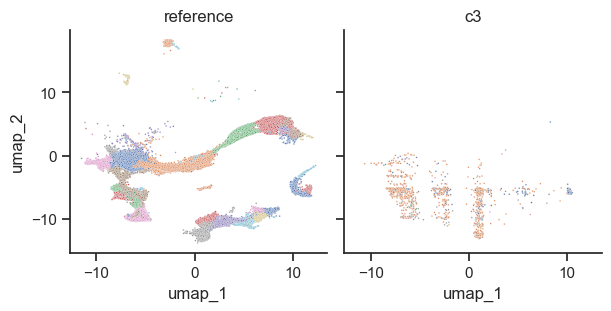

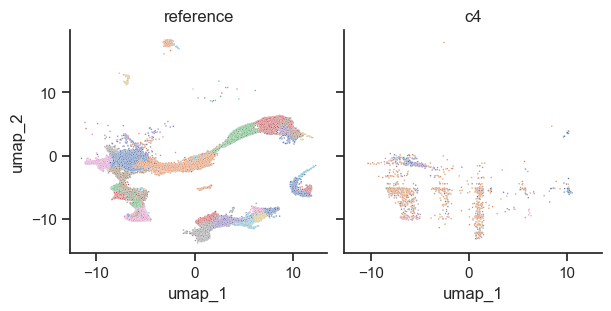

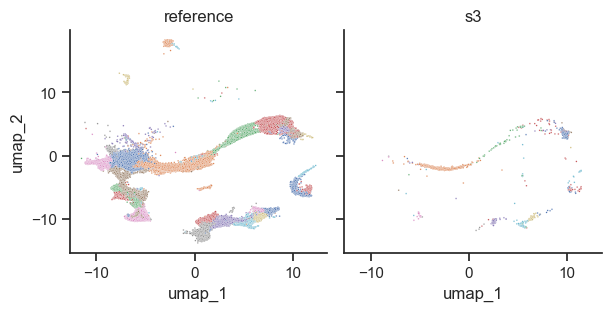

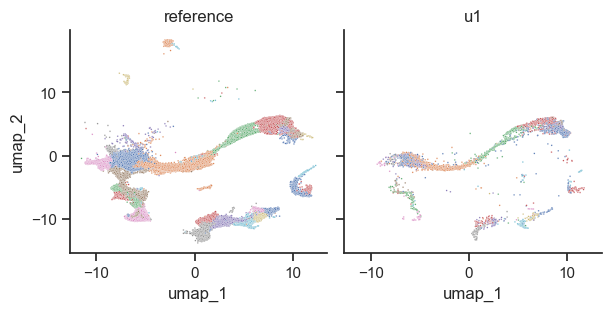

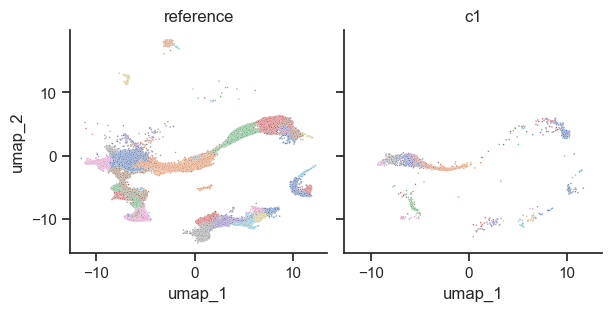

In [15]:
# root directory
base_dir = Path('/Users/ikogbonna/Documents/Lab/Cadwell Lab/Data/barcoded_tech_data')

# directory with reference files
ref_dir = base_dir.joinpath("wang_ref_atlas")
pipeline(
    # path to reference count matrix
    ref_counts_path=ref_dir.joinpath("wang_ref.csv"),
    # path to reference list of variable genes
    ref_genes_path=ref_dir.joinpath("ref_var_genes.csv"),
    # path to reference metadata file
    ref_metadata_path=ref_dir.joinpath("wang_metadata.csv"),
    # path to directory with query datasets to analyze
    query_dir=base_dir.joinpath("sparse_matrices"),
    # path to directory in which to save outputs
    out_dir=base_dir.joinpath("outputs"),
    # labels of umap coordinate columns
    umap_cols=["umap_1", "umap_2"],
    # scale factor with which to normalize count matrices
    scale_factor=10_000,
    # whether to normalize count matrices or not
    norm_seq_depth=True,
    # if True, compute embeddings via median
    use_median=True,
    # number of neighbors to consider for embedding
    knn=10,
    # label of cell type column
    type_col='type_updated',
    # number of cells to load/analyze at a time
    step=1_000
)